# FPP optimization workflow 

In [95]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [96]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

### Modify ini

In [97]:
ini.equilibrium.R0 = 5.0
ini.equilibrium.B0 = 6.0
ini.equilibrium.ip = 8.75e6
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 0.8826 # set less than one so that init uses this as the f_kappa parameter
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 1.5
ini.core_profiles.T_shaping = 1.5
ini.core_profiles.T_ratio = 1.0
ini.core_profiles.greenwald_fraction = 1.2
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.9
ini.core_profiles.helium_fraction = 0.04
ini.core_profiles.zeff = 1.8

ini.build.plasma_gap = 0.125
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = [60e6, 20e6]

ini.pf_active.n_coils_outside = 8

ini.requirements.flattop_duration = 24*3600.0

86400.0

In [98]:
R0 = ini.equilibrium.R0
ϵ = ini.equilibrium.ϵ
a = R0*ϵ

RiPlasma = R0 - a

# HFS layers

ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
ini.build.layers[:hfs_first_wall] = 0.02
ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
    - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
ini.build.layers[:OH] = rbCenterPost * 0.25
ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

# LFS layers

ini.build.layers[:lfs_first_wall] = 0.02
ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.4
ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]

0.4999522355579897

### Modify act

In [99]:
act.ActorEquilibrium.model = :TEQUILA
act.ActorEquilibrium.symmetrize = false

act.ActorECsimple.rho_0 = [0.0,0.6]
act.ActorECsimple.width = [0.05,0.05]

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :Tauenn
act.ActorTauenn.transport_model = :tglfnn
act.ActorTauenn.T_shaping = 1.5
#act.ActorTGLF.user_specified_model = "sat1_em_fpp"


act.ActorStationaryPlasma.convergence_error = 1e-2
act.ActorStationaryPlasma.max_iter = 10
act.ActorStationaryPlasma.do_plot = true

act.ActorTauenn
#act.ActorTGLF


ActorTauenn{Float64}
├─ error ➡ 0.001 Target convergence error
├─ eped_factor ➡ 1.0 Scaling parameter for EPED-NN prediction
├─ rho_fluxmatch ➡ 0.6 Radial location where flux-macthing is done
├─ T_shaping ➡ 1.5 Shaping coefficient for the temperature profile
├─ T_ratio_pedestal ➡ 1.0 Ion to electron temperature ratio in the pedestal
├─ transport_model ➡ :tglfnn Transport model [:tglfnn, :tglf, :h98y2, :ds03]
├─ warn_nn_train_bounds ➡ false Warn if EPED-NN / TGLF-NN training bounds are exceeded
├─ eped_only_powerlaw ➡ false EPED-NN uses power-law pedestal fit (without NN correction)
├─ update_pedestal ➡ true update pedestal with eped_nn inside TAUENN
├─ confinement_factor ➡ 1.0 Confinement multiplier
├─ do_plot ➡ false Plot
└─ verbose ➡ false Verbose


## Run WholeFacility Actor

In [100]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);

[ Info: Equilibrium
[ Info:  TEQUILA
[ Info: HCD
[ Info:  ECsimple
[ Info:  ICsimple
[ Info:  LHsimple
[ Info:  NBsimple
[ Info: SteadyStateCurrent
[ Info: CXbuild


 18.792978 seconds (7.39 M allocations: 2.156 GiB, 1.02% gc time)


[ Info: WholeFacility


[ Info:  StationaryPlasma


Jtor0_before = 25.04 MA/m²
P0_before = 1832.23 kPa
βn_MHD = 3.87
βn_tot = 3.69
Te_ped = 2.80e+03 eV
rho_ped = 0.9500


[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   CoreTransport
[ Info:    Tauenn


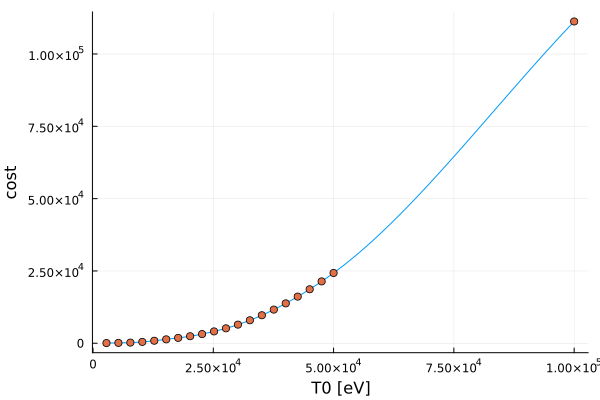

LoadError: No transport solution found

In [101]:
@time FUSE.ActorWholeFacility(dd, act);

## Summary

In [ ]:
#redirect_stdio(stdout="timing.txt") do
#    show(FUSE.timer)
#end


show(FUSE.timer)

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            23.5h /   0.1%           78.5GiB /   8.9%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 WholeFacility              1    80.9s   81.2%   80.9s   4.82GiB   69.1%  4.82GiB
   StationaryPlasma         1    73.4s   73.6%   73.4s   3.70GiB   53.0%  3.70GiB
     Equilibrium            4    24.5s   24.6%   6.13s   2.80GiB   40.1%   716MiB
       TEQUILA              4    24.1s   24.2%   6.03s   2.76GiB   39.6%   707MiB
     CoreTransport          4    1.45s    1.5%   363ms    303MiB    4.2%  75.8MiB
       Tauenn               4    1.19s    1.2%   298ms    303MiB    4.2%  75.6MiB
     HCD       

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 5 [m]                     B0 → 6 [T]                     Te0 → 5.17 [keV]               ne0 → 1.73e+20 [m⁻³]           
a → 1.43 [m]                   ip → 8.56 [MA]                 Ti0 → 5.17 [keV]               ne_ped → 1.04e+20 [m⁻³]        
1/ϵ → 3.5 [m]                  q95 → 6.52                     <Te> → 3.66 [keV]              <ne> → 1.31e+20 [m⁻³]          
κ → 2.15                       <Bpol> → 0.715 [T]             <Ti> → 3.66 [keV]              ne0/<ne> → 1.32                
δ → 0.678                      βpol_MHD → 1.51                Te0/<Te> → 1.41                fGW → 1.1                      
ζ → -0.0278                    βtor_MHD → 0.0204              Ti0/<Ti> → 1.41                zeff_ped → 1.1                 


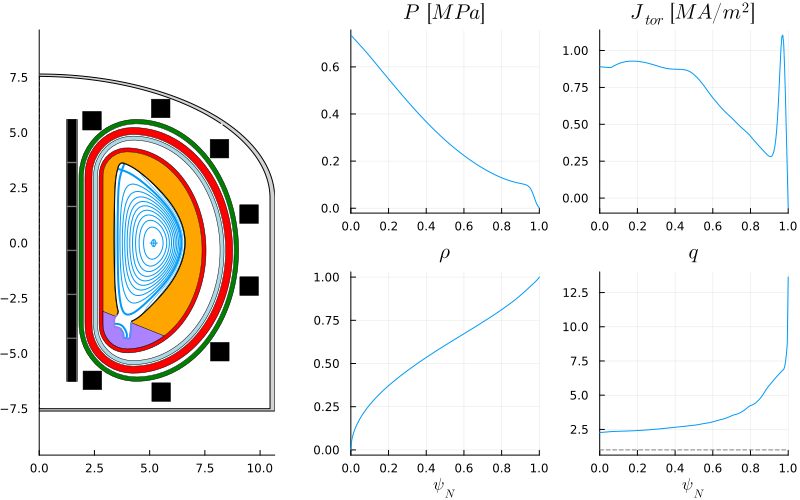

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start   R_end     material      area       volume     
     │ String  String      String    Float64    Float64   Float64   String        Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            1.2342      0.0       1.2342                 14.6332      56.7378
   2 │ in                  oh        0.49409     1.2342    1.72829  ReBCO          5.85814     54.5212
   3 │ in                            0.0714288   1.72829   1.79972                 0.846889     9.38654
   4 │ hfs                 tf        0.200098    1.79972   1.99981  ReBCO          6.17052     77.5338
   5 │ hfs                           0.0714288   1.99981   2.07124                 3.25858    110.429
   6 │ hfs     low temp    shield    0.318144    2.07124   2.38939  Steel          9.05541    286.287
   7 │ hfs                           0.0714288   2.38

​


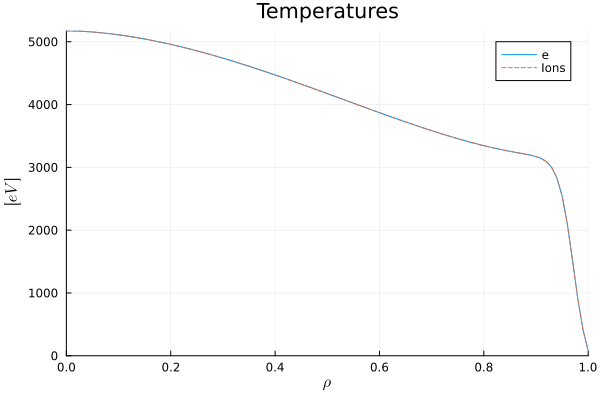

​


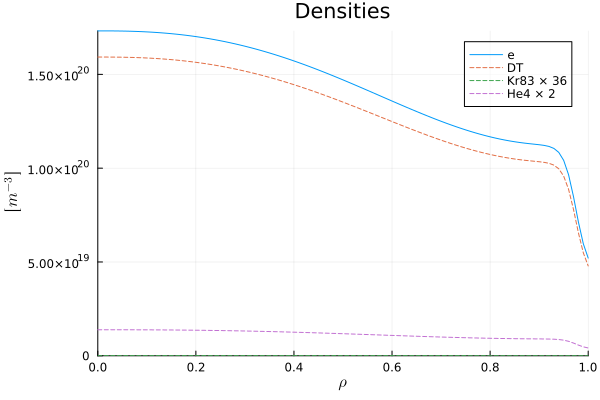

​


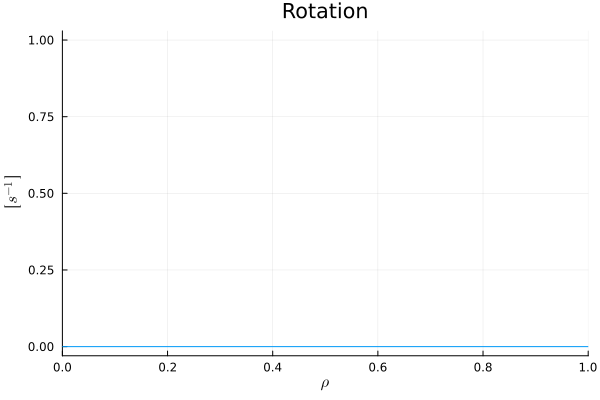

​


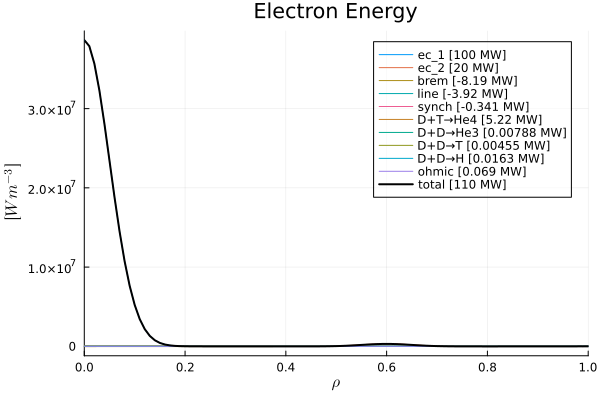

​


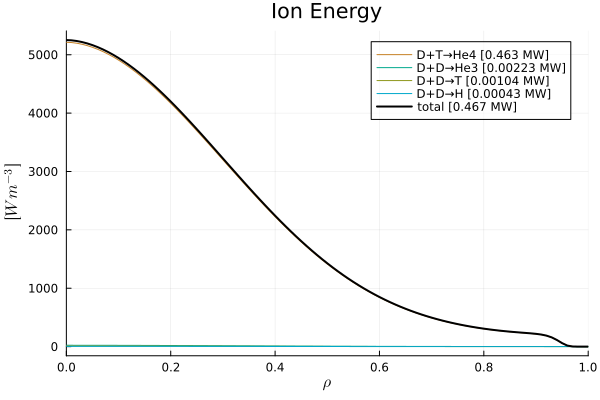

​


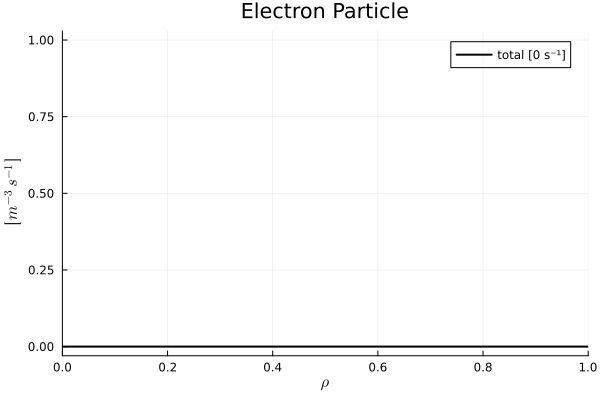

​


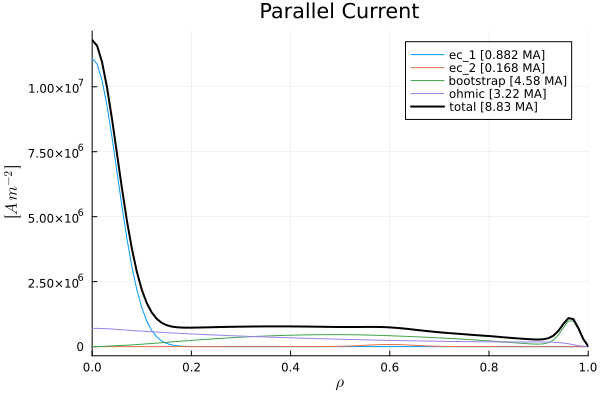

​


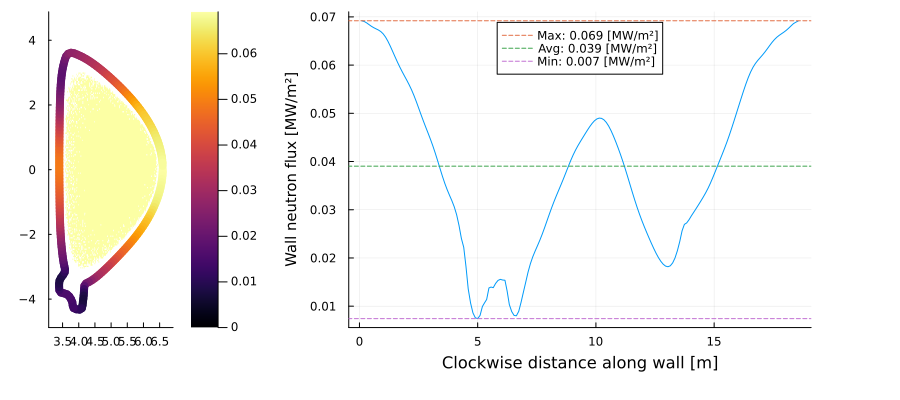

​


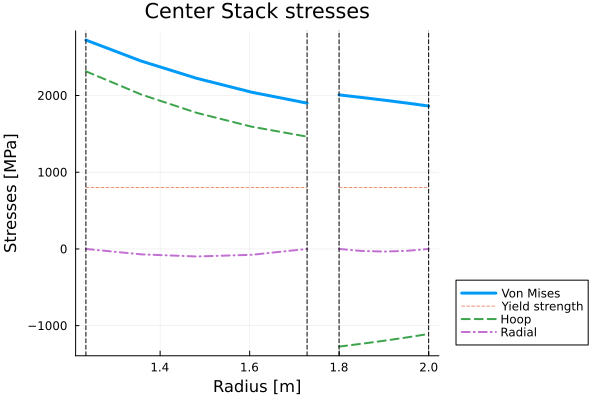

​


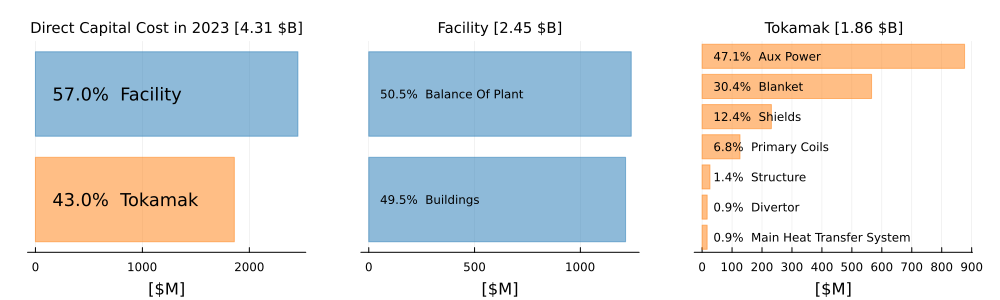

In [ ]:
FUSE.digest(dd)